# **Práctica 1 AAII**
Uxío Merino Currás y Nina López Laudenbach

## Carga do dataset

Esta celda encargarase de baixar o dataset.

In [9]:
import os
import numpy as np
from scipy.special import erf
from tensorflow.keras.utils import get_file

datasets_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/'


def download_dataset(directory):
    dataset_name = 'madelon'

    if not os.path.isdir(directory):
        os.makedirs(directory)

    train_url = datasets_url + dataset_name.lower() + '/'

    for subset in ['train', 'test', 'valid']:
        for option in ['labels', 'data']:
            if option == 'labels' and subset == 'test':
                continue
            filename = dataset_name + '_' + subset + '.' + option
            if subset == 'valid' and option == 'labels':
                url = train_url + dataset_name.lower() + '_' + subset + '.' + option
            else:
                url = train_url + dataset_name.upper() + '/' + dataset_name.lower() + '_' + subset + '.' + option
            if not os.path.exists(directory + '/' + filename):
                get_file(filename, url, cache_dir=directory, cache_subdir='.')


def load_dataset(directory=None):
    directory = './madelon/'
    download_dataset(directory=directory)
    dataset = load_data(directory + 'madelon')
    return dataset


def load_data(source):
    info = {
        'train': {}, 'validation': {}, 'test': {}
    }

    file = source + '_train.labels'
    info['train']['label'] = np.loadtxt(file, dtype=np.int16)
    info['train']['label'][info['train']['label'] < 0] = 0

    file = source + '_train.data'
    info['train']['data'] = np.loadtxt(file, dtype=np.int16).astype(np.float32)

    file = source + '_test.data'
    info['test']['data'] = np.loadtxt(file, dtype=np.int16).astype(np.float32)

    file = source + '_valid.labels'
    info['validation']['label'] = np.loadtxt(file, dtype=np.int16)
    info['validation']['label'][info['validation']['label'] < 0] = 0

    file = source + '_valid.data'
    info['validation']['data'] = np.loadtxt(file, dtype=np.int16).astype(np.float32)

    return info



In [10]:
# Cargamos o dataset
dataset = load_dataset()

## Normalizamos os datos de entrada

Utilizamos a media e a desviación típica para normalizar, xa que observando os datos, considerámolo máis apropiado que usar o máximo e o mínimo.

In [11]:
# Clase para normalizar os datos
class Normalize:

    def __init__(self):
        # Definición das variables
        self.train = np.array(dataset['train']['data'])
        self.atrib = len(self.train[0])
        self.filas = len(self.train)
        self.media = None
        self.std = None
        pass

    def fit(self, X):
        # Función para obter as variables necesarias para a normalización (media e desviación típica)
        self.media = np.mean(self.train, axis=0)
        self.std = np.std(self.train, axis=0)
        pass

    def transform(self, X):
        # Función para normalizar os datos de entrada.
        X = (X - self.media) / self.std
        return X

    def fit_transform(self, X):
        # NON TOCAR: Función para entrenar e transformar os datos simultáneamente (usar só cos datos de entrenamento)
        self.fit(X)
        return self.transform(X)

In [12]:
# Normalizamos os datos
norm_class = Normalize()
dataset['train']['data'] = norm_class.fit_transform(dataset['train']['data']) # Para los datos de entrenamiento
dataset['validation']['data'] = norm_class.transform(dataset['validation']['data']) # Para los datos de validación
dataset['test']['data'] = norm_class.transform(dataset['test']['data']) # Para los datos de test

## Función para crear unha rede

Como podemos ver na siguiente función, creamos o modelo con Sequential() e con .add() engadimos as capas ocultas que lle indiquemos á función.
Para mellorar a precisión do modelo, que se verá máis adiante, probamos a quitarlle a regularización (como se indicou en clase que podíamos facer) á capa de saída que definimos fóra do bucle for.

In [13]:
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras

def crear_red(data, Ncapas, NumNeuronas, FActiv, Regu):
    # Función para crear a rede
    model = tf.keras.models.Sequential() 
    for i in range(Ncapas): 
      model.add(tf.keras.layers.Dense(NumNeuronas, activation=FActiv, kernel_regularizer=tf.keras.regularizers.L2(Regu)))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.build((1,len(data[1])))
    return model

model = crear_red(dataset['train']['data'], 2, 15, 'relu', 1e-5)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (1, 15)                   7515      
                                                                 
 dense_6 (Dense)             (1, 15)                   240       
                                                                 
 dense_7 (Dense)             (1, 1)                    16        
                                                                 
Total params: 7,771
Trainable params: 7,771
Non-trainable params: 0
_________________________________________________________________
None


# Exercicio 2
Para levar a cabo este exericio, definimos en listas os diferentes aspectos para as configuracións que queríamos probar (non aparecen todos os que probamos). 
Creamos un dicionario para ir gardando os resultados (precisión no conxunto de entrenamento e no de validación) segundo os parámetros usados. Para obter estes resultados fixemos un bucle que iterara sobre as listas e fora probando todas as combinacións posibles.

In [14]:
import random
# Valores a probar
Ncapas = [1, 2, 3]
NumNeuronas = [45, 60, 80]
valL2 = [1e-3, 1e-5, 1e-7]
FActiv =  ['selu', 'elu', 'softmax', 'tanh']
# Dicionario para gardar os resultados de entrenamento e validación
dictResult = {}
# Métricas do modelo
fn_perdida = tf.keras.losses.BinaryCrossentropy()
optimizador = tf.keras.optimizers.Adam()
metrica = tf.keras.metrics.BinaryAccuracy()
num_epochs = 100
batch_size = 50

# Variable para gardar o mellor accuracy ata o momento
best = 0

#Poñemos unha semente para obter resultados estables
seed=1234
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Bucle para probar cos diferentes valores
for capa in Ncapas:
  if capa not in dictResult:
    dictResult[capa] = {}
  for neuronas in NumNeuronas:
    if neuronas not in dictResult[capa]:
      dictResult[capa][neuronas] = {}
    for val in valL2:
      if val not in dictResult[capa][neuronas]:
        dictResult[capa][neuronas][val] = {}
      for fun in FActiv:
        if fun not in dictResult[capa][neuronas][val]:
          model = crear_red(dataset['train']['data'], capa, neuronas, fun, val) # Creamos a rede
          model.compile(optimizer=optimizador, loss=fn_perdida, metrics=metrica) # A compilamos 
          model.fit(dataset['train']['data'], dataset['train']['label'], epochs = num_epochs, batch_size=batch_size, verbose = 0) # A entrenamos
          
          result1 = model.evaluate(dataset['train']['data'], dataset['train']['label'], verbose = 0) # Evaluamos co conxunto de entrenamento
          result = model.evaluate(dataset['validation']['data'], dataset['validation']['label'], verbose = 0) # Evaluamos co conxunto de validación
          accuracy_validation = result[1]
          accuracy_train = result1[1]
          print("\nCo conxunto train con " + str(capa) + " capas, " + str(neuronas) + " neuronas, " + str(val) + " valor para L2, " +
          fun + " como función de activacion: \nloss: " + str(result1[0]) + "\taccuracy: " + str(result1[1]))
          print("Co conxunto validation: \nloss: " + str(result[0]) + "\taccuracy: " + str(accuracy_validation))
          
          # Gardamos os parámetros do mellor modelo para poder mostralo abaixo
          if best < accuracy_validation:
              best = accuracy_validation
              par_capas = capa
              par_neuronas = neuronas
              par_valL2 = val
              par_FActiv = fun
              acc_train = accuracy_train
          
          dictResult[capa][neuronas][val][fun] = [accuracy_validation, accuracy_train] # Gardamos no diccionario as precisións para entrenamento e validación de cada modelo



Co conxunto train con 1 capas, 45 neuronas, 0.001 valor para L2, selu como función de activacion: 
loss: 0.06880107522010803	accuracy: 1.0
Co conxunto validation: 
loss: 1.6440273523330688	accuracy: 0.5933333039283752

Co conxunto train con 1 capas, 45 neuronas, 0.001 valor para L2, elu como función de activacion: 
loss: 0.0506400391459465	accuracy: 1.0
Co conxunto validation: 
loss: 1.5824377536773682	accuracy: 0.6200000047683716

Co conxunto train con 1 capas, 45 neuronas, 0.001 valor para L2, softmax como función de activacion: 
loss: 0.080138199031353	accuracy: 1.0
Co conxunto validation: 
loss: 0.8929653763771057	accuracy: 0.6200000047683716

Co conxunto train con 1 capas, 45 neuronas, 0.001 valor para L2, tanh como función de activacion: 
loss: 0.03971535712480545	accuracy: 1.0
Co conxunto validation: 
loss: 1.5446640253067017	accuracy: 0.550000011920929

Co conxunto train con 1 capas, 45 neuronas, 1e-05 valor para L2, selu como función de activacion: 
loss: 0.003096571890637278

In [15]:
# Mostramos o mellor modelo
print('A precisión co conxunto de validación: '+ str(best))
print('A precisión co conxunto de entrenamento: '+ str(acc_train))
print('Número de capas ocultas: ' + str(par_capas))
print('Número de neuronas por capa: ' + str(par_neuronas))
print('Función de activación: ' + str(par_FActiv))
print('Valor para o regularizador por norma L2: ' + str(par_valL2) +"\n")
model.summary()


A precisión co conxunto de validación: 0.653333306312561
A precisión co conxunto de entrenamento: 0.9994999766349792
Número de capas ocultas: 1
Número de neuronas por capa: 60
Función de activación: softmax
Valor para o regularizador por norma L2: 0.001

Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_328 (Dense)           (None, 80)                40080     
                                                                 
 dense_329 (Dense)           (None, 80)                6480      
                                                                 
 dense_330 (Dense)           (None, 80)                6480      
                                                                 
 dense_331 (Dense)           (None, 1)                 81        
                                                                 
Total params: 53,121
Trainable params: 53,121
Non-trainable p

Como podemos ver no mostrado aquí arriba, a precisión do mellor modelo co conxunto de entrenamento é de , mentres que co conxunto de validación é de 65.33%.
Vendo en xeral os resultados da precisión en todos os modelos, podemos afirmar que hai un sobreentrenamento, xa que co conxunto de entrenamento da uns resultados moi bos (moitas veces un 100% de precisión), e co conxunto de validación non da en moitos casos nin un 60%, polo que a xeralización do modelo non é boa.

## Visualiza os resultados

Mostramos en gráficas a seguinte información:

* **Regularización** vs **Número de capas**
* **Regularización** vs **Número de unidades por capa**
* **Número de capas** vs **Número de unidades por capa**

Para os parámetros que non aparecen nos eixos, fixamos o do mellor modelo que obtivemos arriba.

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

def combinacions(capas, neuronas, L2, activacion, t_v):
    # Función para crear a matriz Z que lle imos pasar ao plot, que contén os datos de precisión
    Z = np.zeros((3, 3))
    i = 0
    j = 0
    for x in capas:
      for y in neuronas:
        for w in L2:
          for q in activacion:
            v = dictResult[x][y][w][q][t_v]
            Z[i, j] = v
            j += 1
            if j == 3:
              j = 0
              i += 1
    return Z

# Creamos as matrices de datos
NcapasVSNumNeuronas_V = combinacions(Ncapas, NumNeuronas, [par_valL2], [par_FActiv], 0)
NcapasVSRegularizador_V = combinacions(Ncapas, [par_neuronas], valL2, [par_FActiv], 0)
NumNeuronasVSRegularizador_V = combinacions([par_capas], NumNeuronas, valL2, [par_FActiv], 0)

NcapasVSNumNeuronas_T = combinacions(Ncapas, NumNeuronas, [par_valL2], [par_FActiv], 1)
NcapasVSRegularizador_T = combinacions(Ncapas, [par_neuronas], valL2, [par_FActiv], 1)
NumNeuronasVSRegularizador_T = combinacions([par_capas], NumNeuronas, valL2, [par_FActiv], 1)


def grafica(x, y, z, titulo, vista_x, vista_y):
  # Función para crear as gráficas
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  X = x
  Y = y
  X, Y = np.meshgrid(x, y)
  Z = np.transpose(z)
  surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
  plt.title(titulo)
  ax.view_init(vista_x, vista_y)
  fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.show()



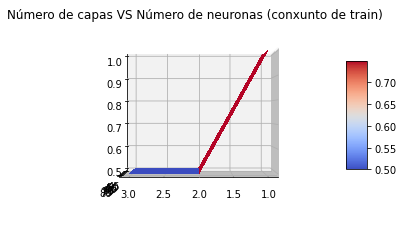

In [18]:
grafica(Ncapas, NumNeuronas, NcapasVSNumNeuronas_T, 'Número de capas VS Número de neuronas (conxunto de train)', 0, 90) ######### esto no es train?

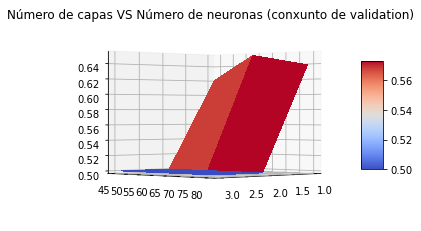

In [19]:
grafica(Ncapas, NumNeuronas, NcapasVSNumNeuronas_V, 'Número de capas VS Número de neuronas (conxunto de validation)', 0, 45)

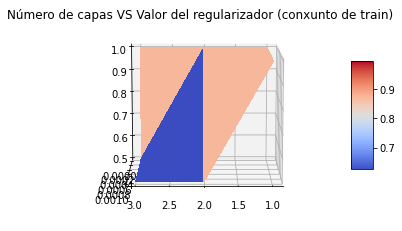

In [20]:
grafica(Ncapas, valL2, NcapasVSRegularizador_T, 'Número de capas VS Valor del regularizador (conxunto de train)', 10, 90)

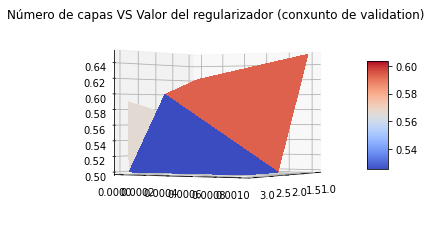

In [21]:
grafica(Ncapas, valL2, NcapasVSRegularizador_V, 'Número de capas VS Valor del regularizador (conxunto de validation)', 0, 30)

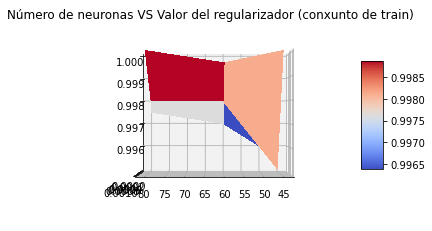

In [22]:
grafica(NumNeuronas, valL2, NumNeuronasVSRegularizador_T, 'Número de neuronas VS Valor del regularizador (conxunto de train)', 0, 90)

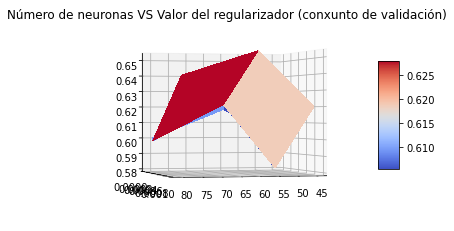

In [23]:
grafica(NumNeuronas, valL2, NumNeuronasVSRegularizador_V, 'Número de neuronas VS Valor del regularizador (conxunto de validación)', 0, 75)

¿Qué crees que está causando a fluctuación nos resultados obtidos?

Unha das problemáticas que podemos apreciar nestas gráficas é o sobreentrenamento mencionado antes. Vemos como nas gráficas correspondentes aos conxuntos de entrenamento, o accuracy máis alto é sempre 1 (ou prácticamente 1), mentres que nas do conxunto de validación non pasa de 0.65.
Ademáis, nas gráficas de train o valor de accuracy alcanza o valor máximo nun plano, non nun só punto, o que quere dicir que é independente dalgún dos parámetros da gráfica. Por exemplo, na primeira gráfica (Número de capas VS Número de neuronas) o valor de accuracy é 1 para todos os valores do número de neuronas cando o valor do número de capas é 1.